# The Multilevel Framework
We will start our journey into the world of mixed-effects models from the perspective of a *multilevel* model. This is primarily because we can build the pieces of a mixed-effects model very slowly from first principles, allowing the logic to become much clearer. In addition, the multilevel framework is often the most *intuitive* way to think about these models, they are just less frequently implemented in this fashion. So, we generally advise to *think* about these models in a multilevel fashion, even if *practically* we end up specifying them in a mixed-effects fashion. This will all become clearer once we have discussed *both* perspectives. 

## Fitting a Model to One Subject
To start understanding multilevel models, let us imagine that we only have the data for *one subject*. Going back to the long-formatted `selfesteem` data from `datarium`, let us extract the data associated with subject 1.

In [1]:
library('datarium')
library('reshape2')

data('selfesteem')

# repeats and number of subjects
t <- 3
n <- dim(selfesteem)[1]

# reshape wide -> long
selfesteem.long <- melt(selfesteem,            # wide data frame
                        id.vars='id',          # what stays fixed?
                        variable.name="time",  # name for the new predictor
                        value.name="score")    # name for the new outcome

selfesteem.long           <- selfesteem.long[order(selfesteem.long$id),] # order by ID
rownames(selfesteem.long) <- seq(1,n*t)                                  # fix row names
selfesteem.long$id        <- as.factor(selfesteem.long$id)               # convert ID to factor

In [2]:
sub.1 <- selfesteem.long[selfesteem.long$id == '1',]
print(sub.1)

  id time    score
1  1   t1 4.005027
2  1   t2 5.182286
3  1   t3 7.107831


So, we can see that we have 3 repeated measurements associated with the 3 values of `time`. Importantly, there are no replications at each time-point, so this is all the information we have available. Now, we know these values will be *correlated* by virtue of coming from the same subject, but we will put that to one side for now because it is a distraction. Instead, our focus here is simply *what model of these data is possible*?

We might be tempted to use

In [3]:
lm.sub.1 <- lm(score ~ time, data=sub.1)

However, there is a problem here. Because each level of `time` is associated with *one* data point, there is no sense in which the parameter estimates can be *average* effects, or *summaries* of any kind. They will simply be *identical* to the raw data. The fitting process aims to minimise the errors, so if it can make them 0 it has done the best job it can. In this example, the model will fit the data *perfectly* and we will be left with *no error*. This means we can get parameter estimates, but nothing else. We *need* residual error for everything else to work. So, we end up with this

In [4]:
summary(lm.sub.1)


Call:
lm(formula = score ~ time, data = sub.1)

Residuals:
ALL 3 residuals are 0: no residual degrees of freedom!

Coefficients:
            Estimate Std. Error t value Pr(>|t|)
(Intercept)    4.005        NaN     NaN      NaN
timet2         1.177        NaN     NaN      NaN
timet3         3.103        NaN     NaN      NaN

Residual standard error: NaN on 0 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:    NaN 
F-statistic:   NaN on 2 and 0 DF,  p-value: NA


This is an important point because the *data* is the element that *constrains* the model. We might *desire* something more complex, but we can only do so if the data supports it. This is quite important to understand as we go forward.

So, if we cannot fit the model we want, what can we fit? Well, because the problem is that we have no replications within each level of `time`, we cannot use the variable `time` at all. Instead, the best we can do is just fit an intercept. The model for subject $i = 1$ from time-point $j$ is simply

$$
\begin{alignat*}{1}
    y_{1j}    &= \mu_{1} + \eta_{1j} \\
    \eta_{1j} &\sim \mathcal{N}\left(0,\sigma^{2}\right)
\end{alignat*}
$$

Where we have used $\eta$ to refer to the errors rather than the usual $\epsilon$, for reasons that will become clearer as we progress. In `R`, this model would be

In [5]:
lm.sub.1 <- lm(score ~ 1, data=sub.1)
summary(lm.sub.1)


Call:
lm(formula = score ~ 1, data = sub.1)

Residuals:
      1       2       3 
-1.4267 -0.2494  1.6761 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)   5.4317     0.9043   6.006   0.0266 *
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.566 on 2 degrees of freedom


So now we have residuals and everything else will work. There is nothing ground-breaking or Earth-shattering about any of this. All we are concluding is that, based on only having a *single* subject from this experiment, the best we could do is model a *subject-specific constant* and nothing else. In this example, the average value of `score` for subject 1 was estimated to be $\hat{\mu}_{1} = 5.43$. That is it.

## Extending the Model to Multiple Subjects
Of course, we do not *only* have subject 1. So let us introduce subject 2 into this framework and see where it gets us. Much like subject 1, if we extract the data for `id == '2'` and consider it in *isolation*, all we can do is the following

In [6]:
sub.2 <- selfesteem.long[selfesteem.long$id == '2',]
print(sub.2)

  id time    score
4  2   t1 2.558124
5  2   t2 6.912915
6  2   t3 6.308434


In [7]:
lm.sub.2 <- lm(score ~ 1, data=sub.2)
summary(lm.sub.2)


Call:
lm(formula = score ~ 1, data = sub.2)

Residuals:
     4      5      6 
-2.702  1.653  1.049 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)  
(Intercept)    5.260      1.362   3.862    0.061 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 2.359 on 2 degrees of freedom


and then conclude that the average `score` for subject 2 is $\hat{\mu}_{2} = 5.260$. In isolation, we therefore have the following two models

$$
\begin{alignat*}{1}
    y_{1j} &= \mu_{1} + \eta_{1j} \\
    y_{2j} &= \mu_{2} + \eta_{2j} \\
\end{alignat*}.
$$

But, of most importance, is that we are not *really* working in isolation. We have *both* subjects together. Recall that the problem with trying to fit an effect of `time` within a single subject was that there were no replications and thus *no variance*. This is true *within* each subject, but *across* the two subjects we *do* have replications of each level of `time`. If we put the two datasets together, we get

In [8]:
rbind(sub.1,sub.2) # row-bind function

  id time    score
1  1   t1 4.005027
2  1   t2 5.182286
3  1   t3 7.107831
4  2   t1 2.558124
5  2   t2 6.912915
6  2   t3 6.308434

So, now we have *two* values of `t1`, *two* values of `t2` and *two* values of `t3`. This means we *can* introduce an effect of `time` that will be estimated *across* the subjects. If we call the effect of the $j$th level of `time` $\alpha_{j}$, we can think of these two models as

$$
\begin{alignat*}{1}
    y_{1j} &= \mu_{1} + \alpha_{j} + \eta_{1j} \\
    y_{2j} &= \mu_{2} + \alpha_{j} + \eta_{2j} \\
\end{alignat*}
$$

which, across all subjects, gives us

$$
y_{ij} = \mu_{i} + \alpha_{j} + \eta_{ij}.
$$

So, we now have a *subject-specific* mean ($\mu_{i}$) and an effect of `time` ($\alpha_{j}$). But notice that there is no subject index on $\alpha_{j}$ meaning that its value is *the same* irrespective of the specific subject. This is important because it indicates that $\alpha_{j}$ captures something *universal* across *all* subjects. 

In `R`, this complete model would be

In [9]:
lm.all.subs <- lm(score ~ id + time, data=selfesteem.long)
summary(lm.all.subs)


Call:
lm(formula = score ~ id + time, data = selfesteem.long)

Residuals:
    Min      1Q  Median      3Q     Max 
-1.3509 -0.5233 -0.0888  0.5304  1.9560 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  3.33503    0.60780   5.487 3.28e-05 ***
id2         -0.17189    0.78466  -0.219  0.82907    
id3          0.39031    0.78466   0.497  0.62491    
id4          0.06107    0.78466   0.078  0.93882    
id5         -1.01940    0.78466  -1.299  0.21029    
id6         -0.75183    0.78466  -0.958  0.35067    
id7         -0.11610    0.78466  -0.148  0.88402    
id8         -0.30895    0.78466  -0.394  0.69840    
id9          0.02795    0.78466   0.036  0.97198    
id10        -0.06029    0.78466  -0.077  0.93960    
timet2       1.79382    0.42978   4.174  0.00057 ***
timet3       4.49622    0.42978  10.462 4.44e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 0.961 on 18 degrees of freedom
Multiple R-squa

So we now have *subject-specific* intercepts, as well as a *universal* effect of `time`. 

In general, what we have done here is create a model that has a *different predicted value for each subject*. Each subject gets their *own model*. Subject 1 is

$$
E(y_{1j}) = \mu_{1} + \alpha_{j} = \mu_{1j},
$$

subject 2 is

$$
E(y_{2j}) = \mu_{2} + \alpha_{j} = \mu_{2j}
$$

and so on. It is like the subjects form the *cells* of the design. Crucially, each subject's expected value is a *combination* of something specific to them $\left(\mu_{1}, \mu_{2}, \dots, \mu_{n}\right)$ and something *universal* from across subjects $\left(\alpha_{1},\alpha_{2},\alpha_{3}\right)$. Thus, this model captures two important elements of our data: the *idiosyncrasies* of the individual and the *constant effect* in the population. 



````{admonition} Connections with the Repeated Measures ANOVA
:class: tip
Hopefully the connections with the repeated measures ANOVA are starting to emerge, but we will make this more explicit later in the lesson.
````

## Understanding $\mu_{i}$ as a *Random Variable*
In order to understand the next steps towards a complete multilevel model, we need to imagine that we ran the experiment *again* and collected a new subject. Take another look at the model

$$
y_{ij} = \mu_{i} + \alpha_{j} + \eta_{ij}
$$

and remember that this is the theoretical *population-level* description of the data-generating process. As such, what do we imagine changes about this description for each *new* subject? Ponder this for a moment.

If we have a new subject, we have a new value of $i$. So which of the terms above depend upon $i$? Certainly $\mu_{i}$ does. Each subject has their own unique mean that is specific to them, so a *new* subject means a *new* value of $\mu_{i}$. In addition, the errors $\eta_{ij}$ depend upon the value of $i$ and will change with every observation. So, when we sample someone new both $\mu_{i}$ and $\eta_{ij}$ will change.

Importantly, what does *not* change is $\alpha_{j}$. Why? Because this has *no* subject-specific index. $\alpha_{1}$ is the same whether $i = 1$ or $i = 1,427$. This is because this is a *universal effect* across all subjects. Its *estimate* would change with another subject (because there is now *more data*), but remember we are thinking about the true population description of the data-generating process here. In this sense, $\alpha_{j}$ is a *constant*. It does not change with each sample, it remains a *fixed* and *unwavering* element of the universe.

So, if $\alpha_{j}$ is *fixed*, what does this mean for $\mu_{i}$ and $\eta_{ij}$? Well, what do we call a variable who's value changes every time we observe it? That's right: a *random variable*. 

So, both $\mu_{i}$ and $\eta_{ij}$ have to be *random variables*. We already know this about $\eta_{ij}$ because we always think of the errors as random and ascribe them a probability distribution. So this is nothing new. What *is* new is having *another random variable in the model*. In fact, pretty much every complication that follows is a direct knock-on effect of having *multiple random variables* in the model.


````{admonition} Fixed-effects and Random-effects
:class: tip
Although we are currently focusing on the *multilevel* perspective, we can already see the *mixed-effects* perspective creeping in. A mixed-effects model is, by definition, a model that contains *both* population-level constants *and* random variables. These are usually referred to as *fixed-effects* and *random-effects*. So, in our example so far we have

- $\alpha_{j}$ - a *fixed-effect* 
- $\mu_{i}$ - a *random-effect*

We will discuss more about what it means to have these different types of effects in a model later in the lesson. For now, the only thing to note is that the *multilevel* and *mixed-effects* frameworks cannot be separated. A discussion of one is naturally a discussion of the other. They are simply different ways of viewing the *same thing*.
````

Because *both* $\mu_{i}$ and $\eta_{ij}$ are *random variables* they will both, by definition, have some probability distribution that describes their behaviour over repeated samples. As we know, the $\eta_{ij}$ are *errors* and thus reflect *deflections* around the expected value. As such, their distribution is the same as it always was 

$$
\eta_{ij} \sim \mathcal{N}\left(0, \sigma^{2}_{1}\right).
$$

But what about the $\mu_{i}$? 

Well, as written above, these are *means* for each subject, so their expected value will not be 0. We saw already that our estimates for the first two subjects from `selfesteem` were $\hat{\mu}_{1} = 5.43$ and $\hat{\mu}_{2} = 5.26$. Clearly these are *not* 0 because they are on the same scale as `score`. So, instead, the expected value of each of these subject-specific means will be whatever the *population grand mean* is. If we stick with the convention of assuming that these subject means are normally distributed, we have

$$
\mu_{i} \sim \mathcal{N}\left(\mu, \sigma^{2}_{2}\right),
$$

where $\mu$ is the grand mean of the population. 

There are several consequences of the assumptions made above. To begin with, there are now *two* probability distributions describing where our data come from. These distributions have different variances ($\sigma^{2}_{1}$ and $\sigma^{2}_{2}$), meaning we have *two* sources of error to now consider. We also need to *estimate* both of these variances from the data in order to complete the unknowns for this model. Last semester, our focus was almost exclusively on the *mean function*, but now we can see that we are shifting focus and adding complexity to the *variance function*. This means that our mental model of where our data comes from now consists of *two layers*. This is precisely the conceptualisation that a multilevel model makes explicit.

## The Complete Multilevel Model
Given the discussions above about the nature of $\eta_{ij}$ and $\mu_{i}$, we can now write our model as

$$
\begin{alignat*}{1}
    y_{ij}        &\sim \mathcal{N}(\mu_{i} + \alpha_{j}, \sigma^{2}_{1}) \\
    \mu_{i}       &\sim \mathcal{N}(\mu , \sigma^{2}_{2})                 \\
\end{alignat*}
$$

In the multilevel framework, these equations are considered multiple *layers* or *levels* of the data, and are usually labelled like so 

$$
\begin{alignat*}{2}
    y_{ij}        &\sim \mathcal{N}(\mu_{i} + \alpha_{j}, \sigma^{2}_{1}) &\quad\text{Level 1} \\
    \mu_{i}       &\sim \mathcal{N}(\mu , \sigma^{2}_{2})                 &\quad\text{Level 2} \\
\end{alignat*}
$$

This also implies a *hierarchy* of data-generation, where the data at Level 1 depends upon the data at Level 2. This is why these types of model are also known as *hierarchical* linear models.

We can also write this model in a slightly different way. As we know from last semester, we can always separate a probability model into an equation for the *fixed* expected value plus *random* error. For instance, we can write a simple regression model as

$$
y_{i} \sim \mathcal{N}(\beta_{0} + \beta_{1}x_{i}, \sigma^{2})
$$

or as

$$
\begin{alignat*}{1}
    y_{i}        &=    \beta_{0} + \beta_{1}x_{i} + \epsilon_{i} \\
    \epsilon_{i} &\sim \mathcal{N}(0, \sigma^{2})                \\
\end{alignat*}
$$

where, in the second form, we move the probabilistic behaviour into a new error term that captures the variation in $y$ around the expected value. So, if we apply the same principles here, we can rewrite the multilevel model as

$$
\begin{alignat*}{2}
    y_{ij}    &= \mu_{i} + \alpha_{j} + \eta_{ij}             &\quad\text{Level 1} \\
    \mu_{i}   &= \mu + \xi_{i}                                &\quad\text{Level 2} \\
    \xi_{i}   &\sim \mathcal{N}\left(0,\sigma^{2}_{1}\right)  &\\
    \eta_{ij} &\sim \mathcal{N}\left(0,\sigma^{2}_{2}\right), &\\
\end{alignat*}
$$

where we have added a new error term $\xi_{i}$[^xi-foot] at Level 2. When written this way, we can see that actually what we have is two models containing *two error terms*. Each of these error terms captures a different form of *random deviation* and thus a different *source of variance*. We can understand this more by discussing each level in turn.

### Level 1
At Level 1, the model is

$$
\begin{alignat*}{1}
    y_{ij}    &=    \mu_{i} + \alpha_{j} + \eta_{ij}         \\
    \eta_{ij} &\sim \mathcal{N}\left(0,\sigma^{2}_{1}\right) \\
\end{alignat*}
$$

So, our data are drawn from a normal distribution with a mean that depends upon two parts: $\mu_{i}$, which is *unique* and *specific* to subject $i$, and $\alpha_{j}$, which is *constant* and *fixed* across subjects. 

At this level, we imagine that the effect of the experimental manipulation is the *same* for every subject. This is no different to our usual assumption about *regression slopes* or *group means* or any other phenomena we are trying to estimate. If we had the *whole population* available we would know $\alpha_{j}$ and our job would be done. The difference now is that we also imagine that each subject is *offset* by an amount unique to them. This implies that the *relative* differences in `score` between the levels of `time` is constant in the population, but that the *absolute* value of `score` depends upon the individual. This captures the idea that a single subject may have an overall *lower* or *higher* value of `score`, because each individual will have their own unique amount of self-esteem. While the `time` manipulation may serve to *increase* or *decrease* self-esteem, someone with *low* self-esteem will still remain *low* even after the effect of `time`. Similarly, someone with *high* self-esteem will still remain *high*, even after the effect of `time`. The measurements from each individual subject are therefore *connected* by the $\mu_{i}$ term. 

Importantly, the errors at this level correspond to deviations in the value of `score` from the unique expected value of each subject. For instance, the errors for subject 1 correspond to the deviation $y_{1j} - (\mu_{1} + \alpha_{j})$, the errors for subject 2 correspond to the deviations $y_{2j} - (\mu_{2} + \alpha_{j})$ and so on. The variance captured by these deviations $\left(\sigma^{2}_{1}\right)$ therefore corresponds to the *internal consistency* of each individual subject. It tells us how much a single subject varies in their value of `score` relative to *their own mean*. So, this is not how much the subjects differ from each other, this is how much each subject differs *from themselves*. As such, we usually call this the *within-subject* variance.


````{admonition} Level 1 Summary
:class: info
In this model, Level 1 explains each subject as an individual entity. Their measured values of `score` can be decomposed into a term unique to them ($\mu_{i}$) and a population-level effect of `time` ($\alpha_{j}$). The errors at this level therefore correspond to deviations in the value of `score` from the unique expected value of each subject. As such, the variance at this level tells us how much the *repeated measurements* differ on average *within* a single subject. 
````


### Level 2
At Level 2, the model is

$$
\begin{alignat*}{1}
    \mu_{i}  &=    \mu + \xi_{i}                             \\
     \xi_{i} &\sim \mathcal{N}\left(0,\sigma^{2}_{2}\right). \\
\end{alignat*}
$$

Here, our outcome variable now consists of the individual *subject means* from Level 1. Because our outcome is always conceived as a *random variable*, this means that $\mu_{i}$ is also a random variable. This fits with our conceptualisation from Level 1, because each $\mu_{i}$ was *unique* to each subject. As such, its value will change with every new sample. Level 2 therefore explains where the individual values of $\mu_{i}$ come from. As written above, we explain each unique value of $\mu_{i}$ as a combination of a *fixed* population-level mean $(\mu)$ and random error $(\xi_{i})$. This is akin to our conceptualisation of a one-sample $t$-test style analysis. Each subject is drawn from an overall population with some constant mean that we want to estimate. The errors at this level therefore correspond to deviations in the subject means from the population mean. As such, the variance at this level $\left(\sigma^{2}_{2}\right)$ corresponds to the *consistency of each subject with the group*. It tells us how much the subjects differ from *each other* and thus captures *between-subjects* variance. 


````{admonition} Level 2 Summary
:class: info
In this model, Level 2 explains the subjects as a group. Each unique subject mean can be decomposed into a group mean $(\mu)$ plus random error. These errors therefore correspond to deviations in the subject means from the group mean. The variance at this level $\left(\sigma^{2}_{2}\right)$ therefore tells us how much the subjects differ *from each other*.
````


### Multilevel Visualisation
To help further conceptualise the multilevel framework, {numref}`multilevel-fig` presents a diagrammatic representation of the model we have been working with so far. To navigate this, start from the *bottom* and work *upwards*. Two sampled datapoints are illustrated as $y_{i1}$ and $y_{i2}$. These are measured values of the repeated measures conditions $j = 1$ and $j = 2$ for subject $i$. These are conceptualised as drawn from individual distributions for that specific subject. The means of these distributions are then a combination of the unique individual subject mean $\mu_{i}$ and the fixed effects of the two conditions, $\alpha_{1}$ and $\alpha_{2}$. The subject mean $\mu_{i}$ is itself conceptualised as a random drawn from the population-level distribution of subjects, with a fixed mean of $\mu$. 

```{figure} images/multilevel-diagram.png
---
width: 500px
name: multilevel-fig
---
An illustration of a basic two-level model.
```

There are a few key takeaways from this illustration. Firstly, every term that contains the index $i$ will change with each new subject. These are therefore all *random variables*. If we conceptualised drawing a new subject, think of every term that contains an $i$ changing and every term that does *not* contain an $i$ staying the same. Secondly, notice that the variance terms $\sigma^{2}_{1}$ and $\sigma^{2}_{2}$ describe different kinds of variation. $\sigma^{2}_{1}$ describes variation *between* different subjects, whereas $\sigma^{2}_{2}$ describes variation *within* a single subject. Finally, we can think of this model as a *generalisation* of everything we have done previously. When our data were independent, we were thinking only in terms of Level 2. So, all the models we were looking at last semester were all representations of Level 2. The addition of repeats for each experimental unit creates the additional level of variation. So, all our previous models were really *single-level* and we can think of them as *special cases* of a multilevel model. From that perspective, the multilevel model is really *the* framework that underlies everything.

## Simulating a Multilevel Model in `R`
As the final section in this part of the lesson, we will look at *simulating* the model above in `R`. This will serve two purposes. Firstly, it can be useful in understanding the abstract representation above by seeing code that implements it. Secondly, there are some not-so-obvious consequences of the multilevel framework that make it particularly suited for repeated measurements. Although these consequences can just be stated, it will make them more concrete when we can actually *see* them via simulation.

In [11]:
set.seed(666)

n.subs <- 50000
n.t    <- 3
y      <- rep(0,n.subs*n.t)

# fixed-effects
mu      <- 5
alpha   <- c(-2,1,3)

# variances
sigma2.1 <- 3 # Level 1 (within-subject)
sigma2.2 <- 2 # Level 2 (between-subjects)

# Level 2
mu.i <- rnorm(n.subs, mean=mu, sd=sqrt(sigma2.2))

# Level 1
idx <- 1
for (i in 1:n.subs){
  for (j in 1:n.t){
    y[idx] <- rnorm(n=1, mean=mu.i[i] + alpha[j], sd=sqrt(sigma2.1))
    idx    <- idx + 1
  }
}

In [12]:
hist(mu.i, main='Level 2')

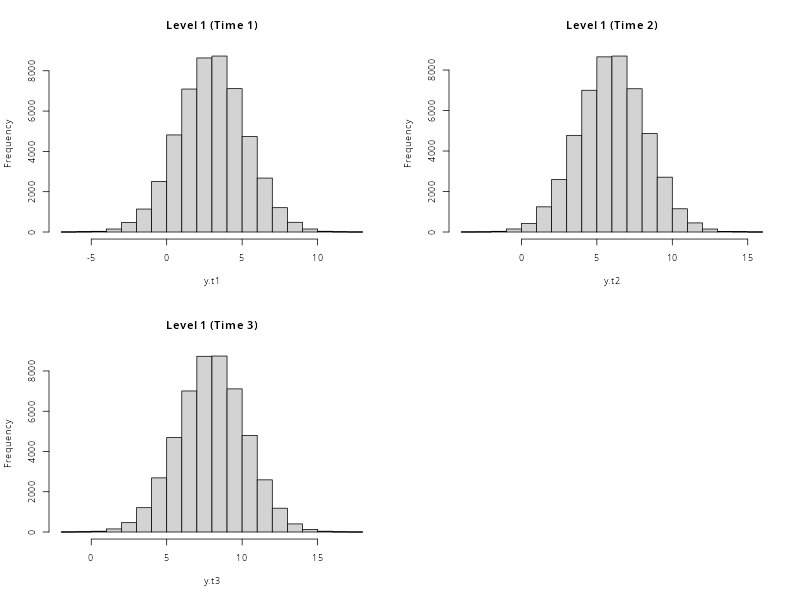

In [13]:
y.t1 <- y[seq(1,n.subs*n.t,3)]
y.t2 <- y[seq(2,n.subs*n.t,3)]
y.t3 <- y[seq(3,n.subs*n.t,3)]

par(mfrow=c(2,2))
hist(y.t1, main='Level 1 (Time 1)')
hist(y.t2, main='Level 1 (Time 2)')
hist(y.t3, main='Level 1 (Time 3)')

Now, for the party trick. Let us first combine together the simulated values of `y` for each time point into different columns of a matrix

In [14]:
Y <- cbind(y.t1,y.t2,y.t3)

Now, let us calculate the variance-covariance matrix of these data

In [15]:
var(Y)

         y.t1     y.t2     y.t3
y.t1 4.999452 2.009662 1.980636
y.t2 2.009662 4.994427 1.994638
y.t3 1.980636 1.994638 4.971735

Notice anything familiar here? For starters, the simulated values of `time` are *correlated*. This is not necessarily surprising, except for the fact that *we did not simulate any correlation*. There is no multivariate normal distribution with a given correlation structure anywhere in the code above. So where did the correlation come from? This is actually a *natural consequence* of the algebra of a multilevel model. We do not need to specify correlation because it happens *automatically* as part of the connection between the levels of the model. This feels a bit like a magic trick, but we can see it clearly above.  

- Multilevel structure creates correlation naturally, without specifying any form of variance-covariance matrix
- Diagonal elements are $\sigma^{2}_{1} + \sigma^{2}_{2} = 2 + 3 = 5$
- Off-diagonal elements are $\sigma^{2}_{1} = 2$
- This structure implies a compound-symmetric covariance matrix

[^xi-foot]: The Greek letter *xi*.